In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastai.vision.all import *
from fastbook import *

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path
path.ls()

(#3) [Path('train'),Path('labels.csv'),Path('valid')]

文件夹下有训练集和验证集

In [4]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

查看第一张图片

In [5]:
im3 = Image.open(threes[1])
im3

numpy数组展示 
图片像素是 28 * 28 的 这里看的其实是左上角的像素值 6*6 二维数组

In [6]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

张量 tensor 展示


In [7]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

打印左上角像素

In [8]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'front-zie':'6px'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


所有3和7的图片的集合，每个图片的像素认为是2阶张量

In [9]:
three_tensors = [tensor(Image.open(o)) for o in threes]
seven_tensors = [tensor(Image.open(o)) for o in sevens]
len(three_tensors),len(seven_tensors)

(6131, 6265)

<AxesSubplot:>

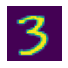

In [10]:
show_image(three_tensors[1])

In [11]:
type(seven_tensors)

list

`stack` 进行张量拼接 有 6131个 (28,28)的图片张量拼接为(6131,28,28) /255是为了归一化，避免梯度过大，造成梯度爆炸，梯度会影响参数的调整率

In [12]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

张量的shape的len是`阶` 也可以叫维度吧

In [13]:
len(stacked_threes.shape)

3

所有图片拼接成的一个张量取平均值，看看平均来的3是怎么样的

mean()会在所有维度上取平均，结果是一个 zero rank值，不是要的平均图片

In [14]:
stacked_threes.mean()

tensor(0.1415)

mean(0) 表示在0维上取平均，所以结果还是一个图片

<AxesSubplot:>

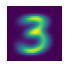

In [15]:
mean3 = stacked_threes.mean(0)
show_image(mean3)

<AxesSubplot:>

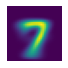

In [16]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

<AxesSubplot:>

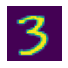

In [17]:
a_3 = stacked_threes[1]
show_image(a_3)

可以分别计算下 这个 3 的张量和 平均的3和7的距离 ，取绝对值或者是平方差是为了拿到正数，不然有正有负很容易抵消

In [18]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [19]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs, dist_7_sqr

(tensor(0.1586), tensor(0.3021))

看到这个图片更接近标准的3

Pytorch提供的两个方法计算 L1(mean absolute value) 和 mse( mean squared error) 

In [20]:
F.l1_loss(a_3.float(), mean7), F.mse_loss(a_3.float(), mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

验证集张量

In [21]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()]).float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()]).float()/255
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

下面的(-1,-2) 表示在倒数1,2维度上进行平均值计算绝对均值误差 和mean(),mean((0,1))效果一样，因为这里是一个二阶张量

In [22]:
def mnist_distance(a, b): return (a-b).abs().mean((-1, -2))
mnist_distance(a_3, mean3)

tensor(0.1114)

这里就看出来为什么上面是(-1,-2)了 3阶张量减去2阶张量的时候 2阶张量会广播扩展为3阶张量，最后两个维度不变

In [23]:
valid_3_dist = mnist_distance(valid_3_tens,mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1328, 0.1523, 0.1245,  ..., 0.1383, 0.1280, 0.1138]),
 torch.Size([1010]))

In [24]:
(valid_3_tens - mean3).shape

torch.Size([1010, 28, 28])

简单的方法: 比较和3，7哪个更接近

In [25]:
def is_3(x): return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [26]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [27]:
is_3(valid_3_tens)

tensor([ True,  True,  True,  ..., False,  True,  True])

计算准确率 取平均值试试

In [28]:
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = (1- is_3(valid_7_tens).float()).mean()
accuracy_3s,accuracy_7s, (accuracy_3s + accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

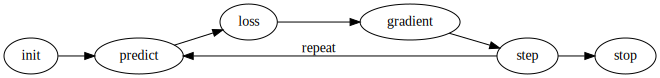

In [29]:

#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')


训练过程

1. 初始化随机值的参数
2. 通过预测计算损失
3. 计算梯度
4. 根据梯度和学习率调整参数
5. 继续预测-计算loss...


解释下损失函数 假设是个平方函数，如下

In [30]:
def f(x): return x**2

In [31]:
doc(plot_function)

plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6, 4))
None

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


假设随机参数初始值是-1.5 loss值如下  
我们可以在斜坡方向稍微改变我们的权重，重新计算我们的损失和调整，并重复几次。最终，我们将到达曲线的最低点：

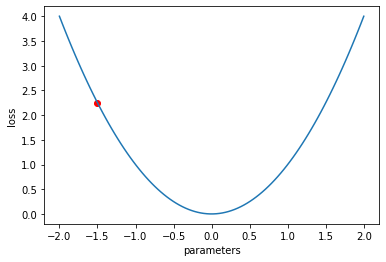

In [32]:
from ipywidgets import interact, interactive, fixed, interact_manual

@interact(x=-1.5)
def plot_f(x):
    plot_function(f, tx='parameters', ty='loss')
    plt.scatter(x, f(x), color='red')

这个基本思想一直追溯到艾萨克牛顿，他指出我们可以用这种方式优化任意函数。无论我们的函数变得多么复杂，梯度下降的这种基本方法都不会发生显着变化。我们将在本书后面看到的唯一微小变化是一些方便的方法，我们可以通过找到更好的步骤来使其更快。
> 函数的导数是描述函数在某一点上变化率的概念，也可以理解为函数图像在该点的切线斜率。如果一个函数在某一点处可导，那么这个点的导数就是该点处的切线斜率。

在 PyTorch 中，我们通常使用自动微分来计算函数的导数，而不是手动计算或使用数值方法。自动微分的基本思想是，通过反向传播算法自动计算函数对输入的导数，从而避免了手动计算和数值方法的复杂性和不精确性。在 PyTorch 中，通过设置 requires_grad=True，可以指定一个张量需要计算导数。然后，通过调用张量的 backward() 方法，即可自动计算导数并保存到对应张量的 grad 属性中。

测试一下获取梯度
创建一个tensor，并且说明我们需要获取导数

In [33]:
xt = tensor(3.).requires_grad_()

In [34]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

然后对yt进行backward 反向误差传播- 就是通过结果计算参数的梯度 所以叫反向

In [35]:
yt.backward()
xt.grad

tensor(6.)

试试多阶张量  因为反向传播的必须是通过一个标量处理   所以这里计算了sum

In [36]:
xt = tensor([3.,4.,10.]).requires_grad_()
def f(x): return (x**2).sum()
yt = f(xt)
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

#### 学习曲线

调整梯度的比例，不能太大或者太小，太小调整次数过多，太大容易越界或者震荡

![](https://raw.githubusercontent.com/fastai/fastbook/823b69e00aa1e1c1a45fe88bd346f11e8f89c1ff//images/chapter2_small.svg)

![](https://raw.githubusercontent.com/fastai/fastbook/823b69e00aa1e1c1a45fe88bd346f11e8f89c1ff//images/chapter2_div.svg)

![](https://raw.githubusercontent.com/fastai/fastbook/823b69e00aa1e1c1a45fe88bd346f11e8f89c1ff//images/chapter2_bouncy.svg)

#### 随机梯度下降 SGD

这里假设的时候有个人记录了20秒内过山车的速度，因为人操作不是很准，图像不会很标准，画个图

创建时间张量,vector

In [37]:
time = torch.arange(0, 20).float()
time, time.shape

(tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.]),
 torch.Size([20]))

速度加点噪音(随机数) 创建了一个20长度的一阶张量，元素是随机正态分布取的，以9.5为中心画个函数

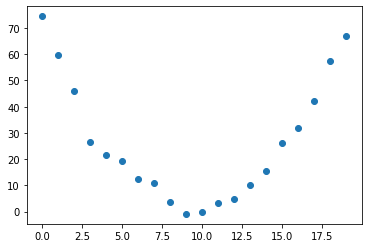

In [38]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 +1
plt.scatter(time,speed)

先假设最佳解决方案是一个二次函数-根据时间和一些参数求速度，这里其实机器学习做的是求参，计算参数，定义个二次函数

In [39]:
def f(time,params):
    a,b,c = params
    return a*(time**2) + b*time + c

定义一个计算我们预测的好坏的的loss 函数，连续值一般使用均方误差(mse)，loss越低表示我们预测的越好

In [40]:
def mse(preds, targets): return ((preds - targets)**2).mean()

下面就按之前说好的7步来

##### 1. 初始化参数

随机初始化三个参数,并告诉pytorch我们需要梯度,保存下初始化得到的参数，以后使用

In [41]:
params = torch.randn(3).requires_grad_()

In [42]:
orig_params = params.clone()

##### 2. 预测

In [43]:
preds = f(time,params)

为了直观看到，画一下，红线是当前参数的曲线

In [44]:
doc(to_np)

to_np(x)
Convert a tensor to a numpy array.

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


In [45]:
def show_preds(preds, ax=None):
    if ax is None: ax = plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300, 100)

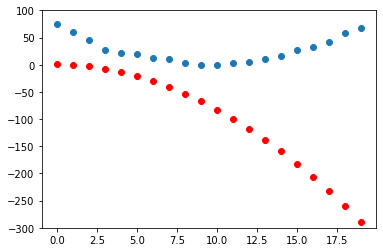

In [46]:
show_preds(preds)

##### 3. 计算loss

In [47]:
loss = mse(preds, speed)
loss

tensor(25823.8086, grad_fn=<MeanBackward0>)

##### 4. 获取梯度

In [48]:
loss.backward()
params.grad

tensor([-53195.8633,  -3419.7148,   -253.8908])

梯度调整

In [49]:
params.grad * 1e-5

tensor([-0.5320, -0.0342, -0.0025])

看下原始参数

In [50]:
params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

##### 5. 调整权重

通过一个学习率 learn rate 来对参数进行微调 一般是 w -= grad*lr  这里用1e-5 = 0.00001  
因为要重新计算会重置下梯度

In [51]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

In [52]:
preds = f(time,params)
mse(preds, speed)

tensor(5435.5356, grad_fn=<MeanBackward0>)

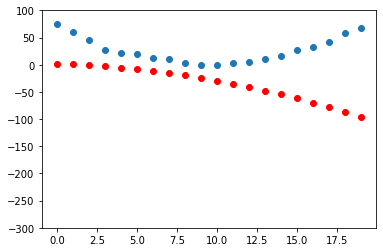

In [53]:
show_preds(preds)

下面要重复跑多次，把这几步抽成一个方法

In [54]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

##### 6. 重复上面过程

In [55]:
for i in range(10): apply_step(params)

5435.53564453125
1577.44921875
847.3778076171875
709.2225341796875
683.0758056640625
678.1243896484375
677.1838989257812
677.0023803710938
676.9645385742188
676.9537353515625


用图来展示下效果

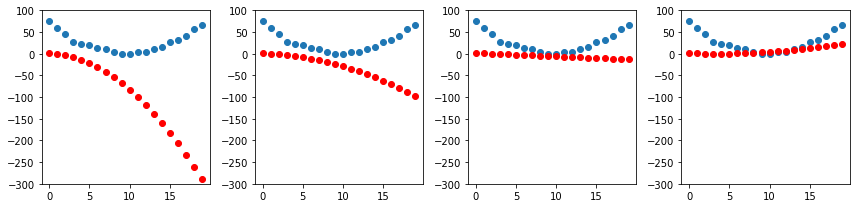

In [56]:
params = orig_params.detach().requires_grad_()
_, axs = plt.subplots(1, 4, figsize=(12, 3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

##### 7. stop

#### MNIST的loss函数

In [57]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_x.shape,len(train_x)

(torch.Size([12396, 784]), 12396)

其实上面就是一个2阶张量 所有图片一维，每个图片里面的像素二维

In [58]:
train_y = tensor([1] * len(threes) + [0] * len(sevens)).unsqueeze(1)
train_y.shape

torch.Size([12396, 1])

unsqueeze 在原张量上加了一个维度 `[1,2,3,4] -> [[1],[2],[3],[4]]`  
这是给训练集打标签 3的标签是1，7的标签是0

In [59]:
tensor([1] * len(threes) + [0] * len(sevens))[0:5]

tensor([1, 1, 1, 1, 1])

通过输入和标签创建一个Pytorch的Dataset

In [60]:
dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

验证集

In [61]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1] * len(valid_3_tens) + [0] * len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

为每个像素创建一个随机权重

In [62]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [63]:
weights = init_params((28*28,1))

如果像素是0的话 权重不管是多少都是0 所有这里要加个偏置
y=w*x+b

In [64]:
bias = init_params(1)

预测一个图片的代码就是

In [65]:
(train_x[0]*weights.T).sum()  + bias

tensor([20.2336], grad_fn=<AddBackward0>)

In [66]:
(train_x[0].unsqueeze(0)*weights.T).sum()  + bias

tensor([20.2336], grad_fn=<AddBackward0>)

weights.T是对矩阵进行转置，为什么要进行转置? * 是逐元素相乘，会对一维张量进行广播为2维张量再相乘，是为了shape一致？

In [67]:
weights.shape,train_x[0].shape,weights[0:5],weights.T.shape

(torch.Size([784, 1]),
 torch.Size([784]),
 tensor([[ 1.3123],
         [ 0.6872],
         [-1.0892],
         [-0.3553],
         [-0.9138]], grad_fn=<SliceBackward0>),
 torch.Size([1, 784]))

python内置矩阵乘法操作符 `@`  

In [68]:
def linear1(xb): return xb@weights + bias

In [69]:
preds = linear1(train_x)
preds

tensor([[20.2336],
        [17.0644],
        [15.2384],
        ...,
        [18.3804],
        [23.8567],
        [28.6816]], grad_fn=<AddBackward0>)

batch@weights + bias 是神经网络最基本的方程之一

计算正确率

In [70]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [71]:
corrects.float().mean().item()

0.4912068545818329

告诉pytorch不要计算梯度，调整权重看看正确率

In [72]:
with torch.no_grad(): weights[0] *= 1.0001

In [73]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.4912068545818329

因为从3-7准确率才会变化 所以这里调整一个权重准确率没什么变化，梯度为0，虽然预测的preds可能变了一些

> 权重值的非常小的变化通常根本不会改变准确度。这意味着使用准确性作为损失函数是没有用的——如果我们这样做，大多数时候我们的梯度实际上是 0，模型将无法从该数字中学习。

我们要一个什么样的loss函数
loss函数的参数是模型的预测和真实值
提出一个参数 prds 值在0-1中间，值是3的预测，每个像素都有，就是一个向量 一维张量
提出一个参数trgts 作为目标，标签 0 / 1 表示是不是3
假设有三个图片 3 7 3 ，模型预测第一个0.9 ，第二个0.4 第三个 0.2
prds和trgts就是这样的

In [74]:
prds = tensor([0.9,0.4,0.2])
trgts = tensor([1, 0, 1])

可以创建一个loss函数

In [75]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [76]:
mnist_loss(prds,trgts)

tensor(0.4333)

问题：prds 要求是0-1之间，怎么将我们的预测结果转到0-1

##### Sigmodi

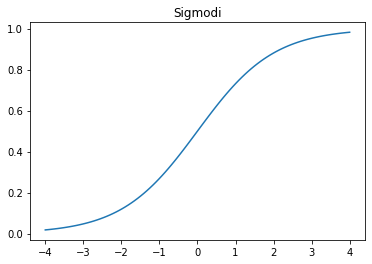

In [77]:
plot_function(torch.sigmoid, title='Sigmodi', min=-4, max=4)

新的loss函数为

In [78]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1,1 - predictions, predictions).mean()

loss函数和准确率的区别是 准确率是给人看的 loss函数是驱动学习的

全部数据的损失计算耗时太大
单个数据的损失计算意义不太
折中取一批数据进行损失计算
同时GPU对一批数据处理有优势，太多也会耗尽显存
批量数据的取法也需要随机取 

In [79]:
coll = range(15)
dl = DataLoader(coll ,batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

pytorch中Dataset是包含相关和不相关变量的元组 inputs  targets 示例

In [80]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

### 合到一起

我们每个epoch的处理类似下面的代码
```python
for x,y in dl:
    pred = model(x)
    loss = loss_func(pred, y)
    loss.backward()
    parameters -= lr * parameters.grad
```

重新初始化权重参数

In [81]:
weights = init_params((28*28,1))
bias = init_params(1)

从DataSet创建一个DataLoader

In [82]:
dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

对验证集做同样的处理

In [83]:
valid_dl = DataLoader(valid_dset, batch_size=256)

取一小批测试下

In [84]:
batch = train_x[:4]
preds = linear1(batch)
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.9998, grad_fn=<MeanBackward0>)

In [85]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-2.7033e-05), tensor([-0.0002]))

抽象到一个函数中

In [86]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [87]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-5.4066e-05), tensor([-0.0004]))

由于多次计算存储梯度 导致结果不同，我们需要先重置梯度

In [88]:
weights.grad.zero_()
bias.grad.zero_()

tensor([0.])

根据学习率和梯度优化，直接操作data  不然也会更新梯度值

> 当我们对参数进行更新时，必须将梯度清零，以确保梯度不会累积

In [89]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad * lr
            p.grad.zero_()

在验证集上检查准确性
大于0.5就算准确

In [90]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [91]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.)

每个epoch进行验证

In [92]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(),4)

In [93]:
validate_epoch(linear1)

0.2875

跑一轮试试

In [94]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.512

In [95]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=" ")

0.6682 0.8144 0.9043 0.9311 0.9433 0.9511 0.9554 0.9598 0.9657 0.9667 0.9677 0.9686 0.9691 0.9691 0.9696 0.9701 0.9701 0.9706 0.9716 0.9716 

pytorch 中 nn.Linear 可以简单的创建一个我们的linear1

In [96]:
linear_model = nn.Linear(28*28,1)

In [97]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

SGD 也是通用的步骤，使用fastai的SGD优化器代码如下

In [98]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [99]:
def train_model(model,epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [100]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 10)

0.4932 0.8969 0.8105 0.9067 0.9316 0.9457 0.955 0.9623 0.9648 0.9662 

fastai 也抽象了 Learner.fit 代替 train_model 可以从数据集和验证集的dataloader创建

In [101]:
dls = DataLoaders(dl, valid_dl)
learn = Learner(dls, nn.Linear(28*28,1),opt_func=SGD,loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636975,0.503117,0.495584,00:00
1,0.427391,0.252948,0.765456,00:00
2,0.160750,0.157115,0.859666,00:00
3,0.072552,0.098883,0.916585,00:00
4,0.039941,0.073976,0.935231,00:00
5,0.027114,0.060023,0.948970,00:00
6,0.021781,0.051199,0.957802,00:00
7,0.019361,0.045256,0.962709,00:00
8,0.018097,0.041033,0.965653,00:00
9,0.017316,0.037893,0.968597,00:00


#### 添加一个非线性层

到目前为止，我们有一个优化函数参数的通用过程，我们已经在一个非常无聊的函数上进行了尝试：一个简单的线性分类器。线性分类器在其功能方面受到很大限制。为了让它更复杂一点（并且能够处理更多的任务），我们需要在两个线性分类器之间添加一些非线性的东西——这就是给我们一个神经网络的原因。

In [102]:
def simple_net(xb):
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

其实上面的max函数就是ReLU函数 输入小于0就是0  大于0就是输入本身
画个曲线

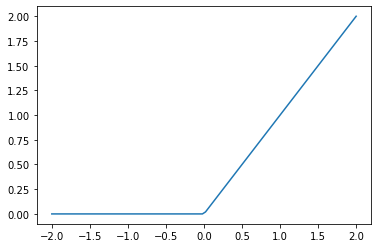

In [103]:
plot_function(F.relu)

使用pytorch简化一下就是
注意下 30是一个可以设置的特征值 表示第一层会输出30个特征值  relu 输入输出都是30   第二个线性层必须也要有30个输入

In [105]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

In [106]:
learn = Learner(dls , simple_net, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

In [107]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.360207,0.411832,0.504907,00:00
1,0.164926,0.252711,0.772816,00:00
2,0.088863,0.121800,0.911678,00:00
3,0.056648,0.080006,0.941119,00:00
4,0.041973,0.061718,0.955348,00:00
5,0.034655,0.051660,0.963690,00:00
6,0.030559,0.045390,0.966143,00:00
7,0.027956,0.041136,0.967125,00:00
8,0.026108,0.038059,0.969087,00:00
9,0.024691,0.035715,0.970559,00:00


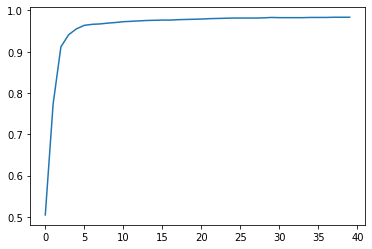

In [109]:
plt.plot(L(learn.recorder.values).itemgot(2));

两个线性层和一个非线性层足以逼近任何函数?那么为什么还需要更多层的模型？
使用更深层的模型可以带来以下几个好处：

更好的表达能力： 更深层的模型可以提供更多的自由度来拟合复杂的非线性关系，从而提高模型的表现力。在某些情况下，单个非线性层可能无法提供足够的表达能力来捕捉数据中的复杂结构。

特征提取： 更深层的模型可以学习到更高级别的特征表示，从而更好地捕捉数据中的抽象概念和关系。这对于处理复杂的视觉和语音数据等具有高维度输入空间的问题特别重要。

> 在深度学习中，神经网络的每一层都可以看作是对输入数据的一种特征提取器。每一层将输入数据转换为一组新的特征，这些特征对于下一层的特征提取和分类任务更有用。在更深层的神经网络中，每个层都可以学习到不同级别的特征表示，从低级别的特征（例如边缘、角点、颜色）到高级别的特征（例如物体部件、形状、纹理）。这是因为每一层都可以对前一层的特征进行组合和变换，从而提取出更为抽象和高层次的特征表示

防止过拟合： 更深层的模型可以通过堆叠多个层来增加模型的复杂度，同时可以使用正则化方法来防止过拟合。这些技术包括 Dropout、Batch Normalization 和权重衰减等。

训练效率： 深层模型通常可以通过并行计算来提高训练效率，因为在训练时可以将每层的计算分配到不同的处理器上。此外，深层模型还可以使用预训练技术，如自编码器和迁移学习，来加速训练过程